# Телекоммуникации

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель:** построить модель для задачи классификации, которая спрогнозирует уход клиента 

**Основная метрика: AUC-ROC.**    
Дополнительная метрика: Accuracy.

**Критерии оценки:**    
•AUC-ROC >= 0.85

**Описание данных:**      

Данные состоят из файлов, полученных из разных источников:   

- contract_new.csv — информация о договоре;   
- personal_new.csv — персональные данные клиента;   
- internet_new.csv — информация об интернет-услугах;   
- phone_new.csv — информация об услугах телефонии.   

Во всех файлах столбец customerID содержит код клиента.  

Информация о договорах актуальна на 1 февраля 2020.

**Признаки:**   

contract_new.csv:    
- customerID - идентифакионный номер покупателя
- BeginDate - дата начала обслуживания 
- EndDate - дата окончания обслуживания
- Type - тип оплаты: месяц, год, два
- PaperlessBilling - безналичный расчет
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячные траты на услуги
- TotalCharges - всего потрачено денег на услуги

personal_new.csv:  
- customerID - идентифакионный номер покупателя  
- gender - пол покупателя   
- SeniorCitizen	- наличие пенсионного статуса по возрасту 
- Partner -  наличие супруга(и)
- Dependents - наличие иждивенцев

internet_new.csv:  
- customerID - идентифакионный номер покупателя  
- InternetService - тип подключения
- OnlineSecurity - блокировка небезопасных сайтов 
- OnlineBackup - облачное хранилище файлов для резервного копирования данных
- DeviceProtection - защита устройства  
- TechSupport - линия технической поддержки
- StreamingTV - телевидение  
- StreamingMovies - каталог фильмов

phone_new.csv:
- customerID - идентифакионный номер покупателя  
- MultipleLines - наличие возможности ведения параллельных линий во время звонка

<div class="alert alert-block alert-info">
<h1> План работы:</h1>

 1. Загрузка и изучение данных.       
    
   проверим:
   - стиль написания столбцов
   - соответствуют ли типы данных
   - дубликаты
   - дубликаты по id
   - пропуски
    
    
 2. Предобработка данных 
   - объединим таблицы по customerID
   - приведём названия столбцов к snake-case
   - создадим новый столбец(таргет) на основании значений EndDate 
   - создадим столбец продолжительности сотрудничества на разнице EndDate и BeginDate
   - заполним появившиеся пропуски
   - изменим типы данных
   - рассмотрим присутствие аномальных значений 
   - проверим признаки на мультиколлинеарность и при её наличии удалим лишние столбцы (в дальнейшем при подготовке данных для обучения моделей)

    
 3. Исследовательский анализ данных
   - визуализируем распределение признаков
   - через библиотеку "phik" посмотрим на корреляцию признаков и значимость коэффициентов
   - (возможно) рассмотрим зависимость таргета от других признаков при помощи сводных таблиц, матрицы корреляции или просто scatter
  
    
 4. Подготовка данных к обучению
   - удалим лишние столбцы (на основе полученных ранее результатов)
   - разобьём данные на выборки
   
    
 5. Обучение моделей
   - при помощи GridSearch подберём гиперпараметры для моделей, используя конвейер, в котором мы закодируем категориальные признаки и масштабируем числовые для некоторых моделей (насколько я помню, у CatBoost и Light встоенный кодировщик)
   - вычислим необходимые метрики
   - выберем лучшую модель

    
 6. Тестирование модели
  - протестируем лучшую модель на тестовой выборке
  - построим матрицу ошибок
  - проверим модель на адекватность
  
    
 7. Выводы
</div>

In [1]:
!pip install -U -q skimpy
!pip install -q phik
!pip install -q pandas==1.5.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.25.2 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.25.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skimpy 0.0.10 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import phik
import urllib.request

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, \
                            accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier


from skimpy import clean_columns

from time import time

import warnings
warnings.simplefilter('ignore')

# pandas показывает все колонки без усечения
pd.options.display.max_columns = None

RANDOM_STATE = 280823
DATA_LOAD = '2020-02-01'

## Загрузка и изучение данных.

In [3]:
# collab

# url = 'https://code.s3.yandex.net/datasets/contract_new.csv'
# urllib.request.urlretrieve(url, 'contract_new.csv')
# url = 'https://code.s3.yandex.net/datasets/personal_new.csv'
# urllib.request.urlretrieve(url, 'personal_new.csv')
# url = 'https://code.s3.yandex.net/datasets/internet_new.csv'
# urllib.request.urlretrieve(url, 'internet_new.csv')
# url = 'https://code.s3.yandex.net/datasets/phone_new.csv'
# urllib.request.urlretrieve(url, 'phone_new.csv')

In [4]:
# collab

# df_contract = pd.read_csv('./contract_new.csv')
# df_personal = pd.read_csv('./personal_new.csv')
# df_internet = pd.read_csv('./internet_new.csv')
# df_phone = pd.read_csv('./phone_new.csv')

In [5]:
if os.path.exists('/datasets/contract_new.csv'):
    df_contract = pd.read_csv('/datasets/contract_new.csv')
else:
    print('Nothing works.')

In [6]:
if os.path.exists('/datasets/personal_new.csv'):
    df_personal = pd.read_csv('/datasets/personal_new.csv')
else:
    print('Nothing works.')

In [7]:
if os.path.exists('/datasets/internet_new.csv'):
    df_internet = pd.read_csv('/datasets/internet_new.csv')
else:
    print('Nothing works.')

In [8]:
if os.path.exists('/datasets/phone_new.csv'):
    df_phone = pd.read_csv('/datasets/phone_new.csv')
else:
    print('Nothing works.')

In [9]:
# напишем функцию для описания и просмотра данных
def description(df):
    display(df.head(10))
    display(df.info())
    display(df.describe(include='all'))
    print('Количество дубликатов', df.duplicated().sum())
    print('Количество дубликатов по "id"', df['customerID'].duplicated().sum())
    print('Количество пропусков:', df.isna().sum().sum())

In [10]:
description(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Количество дубликатов 0
Количество дубликатов по "id" 0
Количество пропусков: 0


In [11]:
description(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Количество дубликатов 0
Количество дубликатов по "id" 0
Количество пропусков: 0


In [12]:
description(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество дубликатов 0
Количество дубликатов по "id" 0
Количество пропусков: 0


In [13]:
description(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Количество дубликатов 0
Количество дубликатов по "id" 0
Количество пропусков: 0


**Вывод по пункту 1:**   
 - пропусков нет, пока
 - дубликаты отсутствуют
 - нужно объединить таблицы
 - нужно привести названия столбцов к snake-case
 - изменить тип данных "TotalCharges" на float
 - для исследовательского анализа можно привести типы в столбцах EndDate и BeginDate к дате

## Предобработка данных

### Объединение таблиц

In [14]:
data = df_contract.merge(df_personal, on='customerID', how='left')\
                .merge(df_phone, on='customerID', how='left')\
                .merge(df_internet, on='customerID', how='left')
df = data.copy()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


### Приведём названия столбцов к snake-case

In [16]:
df = clean_columns(df)

In [17]:
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

### Cоздадим новый столбец(таргет) на основании значений EndDate

In [18]:
df['gone'] = df['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [19]:
df.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gone
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,NaN,DSL,Yes,No,No,No,No,No,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,No,DSL,Yes,Yes,No,No,No,No,1


In [20]:
len(df.query('end_date == "No"')) == len(df.query('gone == 0'))

True

In [21]:
len(df.query('end_date == "No"'))

5942

### Cоздадим столбец продолжительности сотрудничества

In [22]:
# сначала заменим значение 'No' на DATA_LOAD
df.loc[df['end_date'] == 'No', 'end_date'] = DATA_LOAD

In [23]:
# изменим тип данных на datetime
df[['begin_date', 'end_date']] = df[['begin_date', 'end_date']].apply(pd.to_datetime)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     6361 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

In [25]:
# создадим новый столбец продолжительности сотрудничества в днях
df.insert((len(df.columns) - 1), 
          'collab_day', 
          df['end_date'].dt.to_period('D').astype(int) - df['begin_date'].dt.to_period('D').astype(int))

In [26]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,collab_day,gone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,1036,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,123,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,1371,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,153,0


### Заполним появившиеся пропуски

In [27]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
collab_day              0
gone                    0
dtype: int64

**Так как пропуски у нас появились у людей, которые не пользуются услугами интернета или услугой параллельных линий, заполним их "No"**

In [28]:
df.fillna('No', inplace = True)

In [29]:
df.isna().sum().sum()

0

### Изменим типы данных и рассмотрим присутствие аномальных значений

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

In [31]:
# посмотрим на строки не соответствующие шаблону float
df[~df.total_charges.str.contains(r'\d+.\d+')]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,collab_day,gone
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,No,DSL,Yes,No,Yes,Yes,Yes,No,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,0,0


**Это люди, которые только подключились и, соответственно, еще не платили.**

In [32]:
df.total_charges.replace(' ', 0, inplace=True)

In [33]:
df[df.index == 488]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,collab_day,gone
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0,Female,0,Yes,Yes,No,DSL,Yes,No,Yes,Yes,Yes,No,0,0


In [34]:
df.total_charges = pd.to_numeric(df.total_charges)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  multiple_lines     7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

In [36]:
col_obj = df.select_dtypes(include=['object']).columns
col_obj

Index(['customer_id', 'type', 'paperless_billing', 'payment_method', 'gender',
       'partner', 'dependents', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies'],
      dtype='object')

In [37]:
df[col_obj] = df[col_obj].astype('category')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   category      
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   category      
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   category      
 11  dependents         7043 non-null   category      
 12  multiple_lines     7043 non-null   category      
 13  internet_service   7043 non-null   category      
 14  online_s

In [39]:
df.describe(include='all')
print('Количество дубликатов', df.duplicated().sum())
print('Количество дубликатов по "id"', df['customer_id'].duplicated().sum())
print('Количество пропусков:', df.isna().sum().sum())

Количество дубликатов 0
Количество дубликатов по "id" 0
Количество пропусков: 0


**Вывод по пункту 2:**   
   - объединили таблицы
   - привели названия столбцов к snake-case
   - создали новый столбец(таргет) на основании значений EndDate 
   - создали столбец продолжительности сотрудничества на разнице дат
   - заполнили появившиеся пропуски
   - изменили типы данных
   - исправили строки в total_charges, других аномалий не обнаружено

## Исследовательский анализ данных

### Распределение таргета.

0    0.843675
1    0.156325
Name: gone, dtype: float64


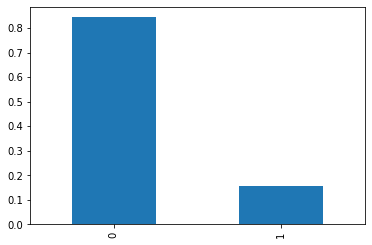

In [40]:
separation = df['gone'].value_counts(normalize=True)
print(separation)
separation.plot(kind='bar');

### Распределение признаков и зависимость таргета от других признаков

In [41]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,collab_day,gone
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,No,DSL,No,Yes,No,No,No,No,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No,1036,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No,123,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,No,DSL,Yes,No,Yes,Yes,No,No,1371,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No,153,0


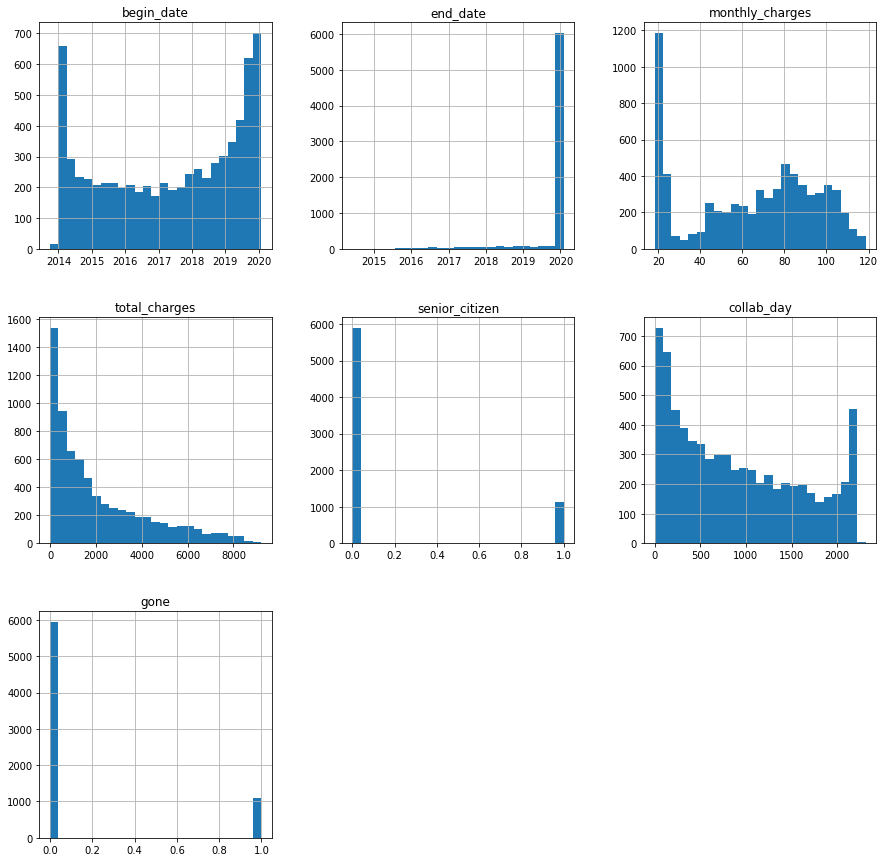

In [42]:
# строим гистограммы для датафрейма
df.hist(figsize=(15, 15), bins=25)
plt.show()

### Средняя продолжительность сотрудничества в зависимости от месяца подключения

In [43]:
data_bcm = df.groupby(df['begin_date'].dt.month)['customer_id'].count()
data_bcm

begin_date
1     623
2     804
3     590
4     511
5     494
6     522
7     518
8     532
9     623
10    601
11    621
12    604
Name: customer_id, dtype: int64

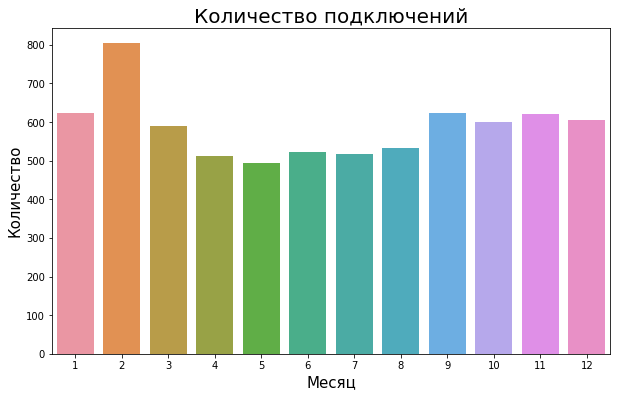

In [44]:
plt.figure(figsize=(10, 6))    
sns.barplot(x=data_bcm.index, y=data_bcm.values)
plt.title('Количество подключений', fontsize=20)
plt.xlabel('Месяц', fontsize=15)
plt.ylabel('Количество', fontsize=15);

**Количество подключений не сильно зависит от месяца**

### Cредняя продолжительность сотрудничества в зависимости от типа оплаты

In [45]:
data_tc = df.groupby('type')['collab_day'].mean()
data_tc

type
Month-to-month     526.825548
One year          1142.544467
Two year          1536.348673
Name: collab_day, dtype: float64

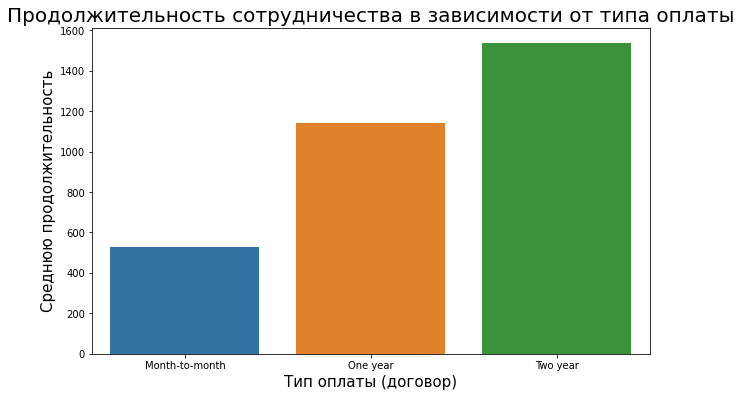

In [46]:
plt.figure(figsize=(10, 6))    
sns.barplot(x=data_tc.index, y=data_tc.values)
plt.title('Продолжительность сотрудничества в зависимости от типа оплаты', fontsize=20)
plt.xlabel('Тип оплаты (договор)', fontsize=15)
plt.ylabel('Среднюю продолжительность', fontsize=15);

**Продолжительность сотрудничества зависит от договора оплаты**

### Разница между пришедшими и ушедшими клиентами

In [47]:
# сколько клиентов ушло
data_eg = df.groupby(df['end_date'].dt.year)['gone'].sum()
data_eg

end_date
2014      7
2015     62
2016    140
2017    235
2018    285
2019    333
2020     39
Name: gone, dtype: int64

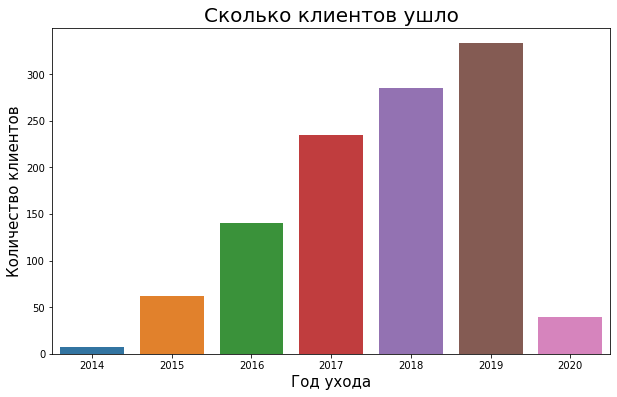

In [48]:
plt.figure(figsize=(10, 6))    
sns.barplot(x=data_eg.index, y=data_eg.values)
plt.title('Сколько клиентов ушло', fontsize=20)
plt.xlabel('Год ухода', fontsize=15)
plt.ylabel('Количество клиентов', fontsize=15);

**Количество стало расти, но мы не учли сколько пришло клиентов. Возможно, стало больше приходить.**

**Посмотрим сколько клиентов приходило из года в год**

In [49]:
data_bcy = df.groupby(df['begin_date'].dt.year)['customer_id'].count()
data_bcy

begin_date
2013       8
2014    1344
2015     852
2016     763
2017     845
2018    1030
2019    1957
2020     244
Name: customer_id, dtype: int64

**Найдём разницу**

In [50]:
data_diff = pd.concat([data_eg, data_bcy], axis= 1 )
data_diff = data_diff.fillna(0).astype(int)
data_diff.index.name='year'
data_diff['diff'] = data_diff['customer_id'] - data_diff['gone']
data_diff

,gone,customer_id,diff
year,,,
2014,7,1344,1337
2015,62,852,790
2016,140,763,623
2017,235,845,610
2018,285,1030,745
2019,333,1957,1624
2020,39,244,205
2013,0,8,8


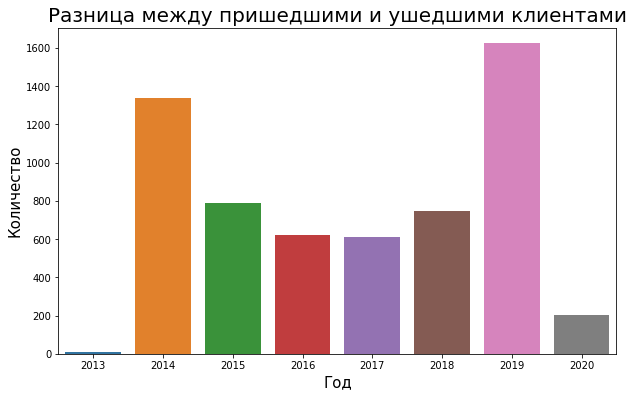

In [51]:
plt.figure(figsize=(10, 6))    
sns.barplot(x=data_diff.index, y=data_diff['diff'])
plt.title('Разница между пришедшими и ушедшими клиентами', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Количество', fontsize=15);

**В 2019 количество ушедших клиентов сильно увеличилось, видимо нашли более выгодное предложение.**

### Дата заключения договора

In [52]:
df0 = df[df['gone'] == 0]

In [53]:
len(df0)

5942

In [54]:
df1 = df[df['gone'] == 1]

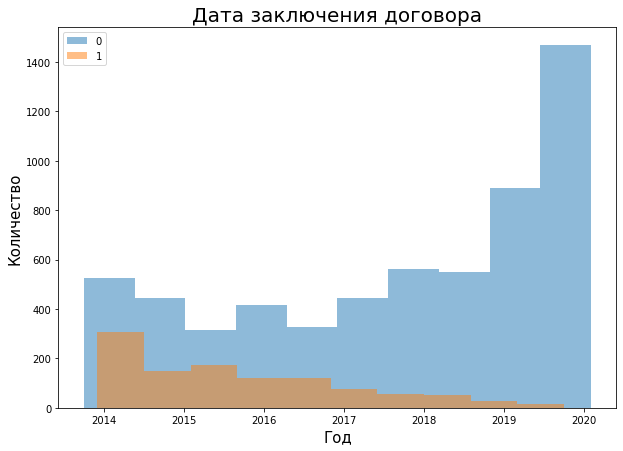

In [55]:
plt.figure(figsize=(10, 7))
plt.hist(df0['begin_date'], alpha=0.5, label='0')
plt.hist(df1['begin_date'], alpha=0.5, label='1')
plt.title('Дата заключения договора', fontsize=20)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.legend();

**Как мы видим, ушли клиенты, которые пришли к оператору связи в самом начале.**

### Ежемесячные траты на услуги

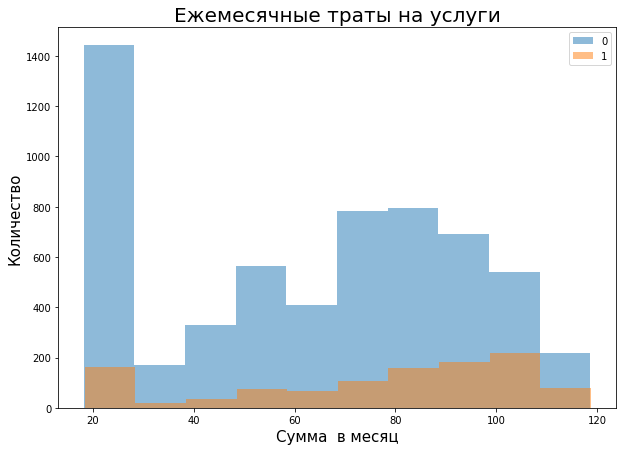

In [56]:
plt.figure(figsize=(10, 7))
plt.hist(df0['monthly_charges'], alpha=0.5, label='0')
plt.hist(df1['monthly_charges'], alpha=0.5, label='1')
plt.title('Ежемесячные траты на услуги', fontsize=20)
plt.xlabel('Сумма  в месяц', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.legend();

**Распределение примерно одинаковое**

### Как влияет наличие партнёра

In [57]:
data_pc0 = df0.groupby('partner')['customer_id'].count()
data_pc1 = df1.groupby('partner')['customer_id'].count()

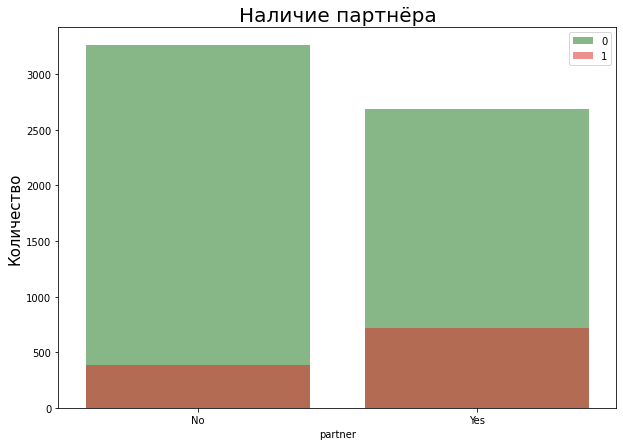

In [58]:
plt.figure(figsize=(10, 7))
sns.barplot(x=data_pc0.index, y=data_pc0.values, alpha=0.5, label='0', color='g')
sns.barplot(x=data_pc1.index, y=data_pc1.values, alpha=0.5, label='1', color='r')
plt.title('Наличие партнёра', fontsize=20)
plt.ylabel('Количество', fontsize=15)
plt.legend();

**Мы видим, что люди состоящие в браке уходят гораздо чаще.**

### Пенсонер или нет

In [59]:
data_sc0 = df0.groupby('senior_citizen')['customer_id'].count()
data_sc1 = df1.groupby('senior_citizen')['customer_id'].count()

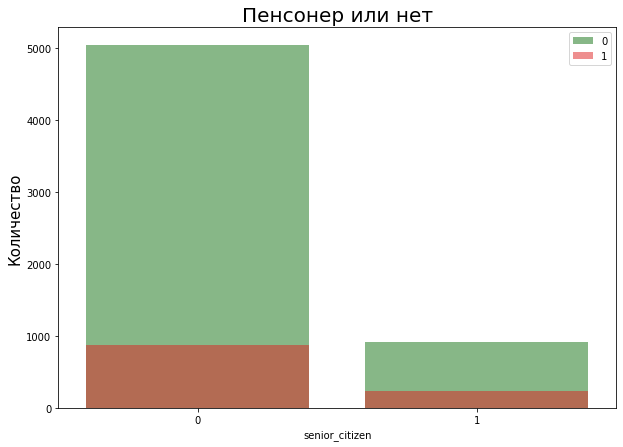

In [60]:
plt.figure(figsize=(10, 7))
sns.barplot(x=data_sc0.index, y=data_sc0.values, alpha=0.5, label='0', color='g')
sns.barplot(x=data_sc1.index, y=data_sc1.values, alpha=0.5, label='1', color='r')
plt.title('Пенсонер или нет', fontsize=20)
plt.ylabel('Количество', fontsize=15)
plt.legend();

**Особых различий нет.**

### Корреляция признаков и значимость коэффициентов

In [61]:
df = df.drop('customer_id', axis=1)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'collab_day', 'gone']


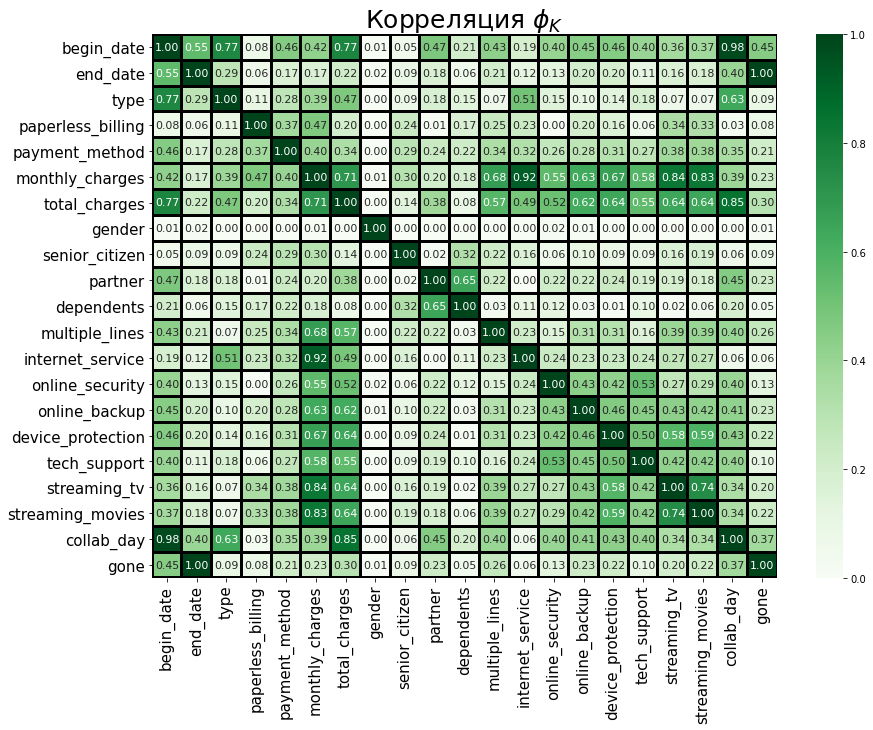

CPU times: user 4.2 s, sys: 592 ms, total: 4.79 s
Wall time: 4.82 s


In [62]:
%%time
plt.figure(figsize = (14, 10))
ax = plt.axes()
sns.heatmap(df.phik_matrix(),
            annot=True,
            annot_kws={'size':11},
            fmt='.2f',
            cmap='Greens',
            linewidths=2,
            linecolor='black')
plt.title(r'Корреляция $\phi_K$', fontsize=25)
plt.tick_params(labelsize=15) 
plt.show()

**Вывод по пункту 3:**   
- распределение таргета не равномерно 6:1   
- продолжительность сотрудничества зависит от договора оплаты 
- в 2019 количество ушедших клиентов сильно увеличилось   
- ушли клиенты, которые пришли к оператору связи в самом начале  
- люди состоящие в браке уходят гораздо чаще
- мы удалим столбцы 'customer_id'    
- также присутствует мультиколлениарность фичей "monthly_charges" с "internet_service", "streaming_tv", "streaming_movies".

## Подготовка данных к обучению

### Удалим лишние столбцы

In [64]:
df = df.drop(['begin_date', 'end_date'], axis=1)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'collab_day', 'gone']


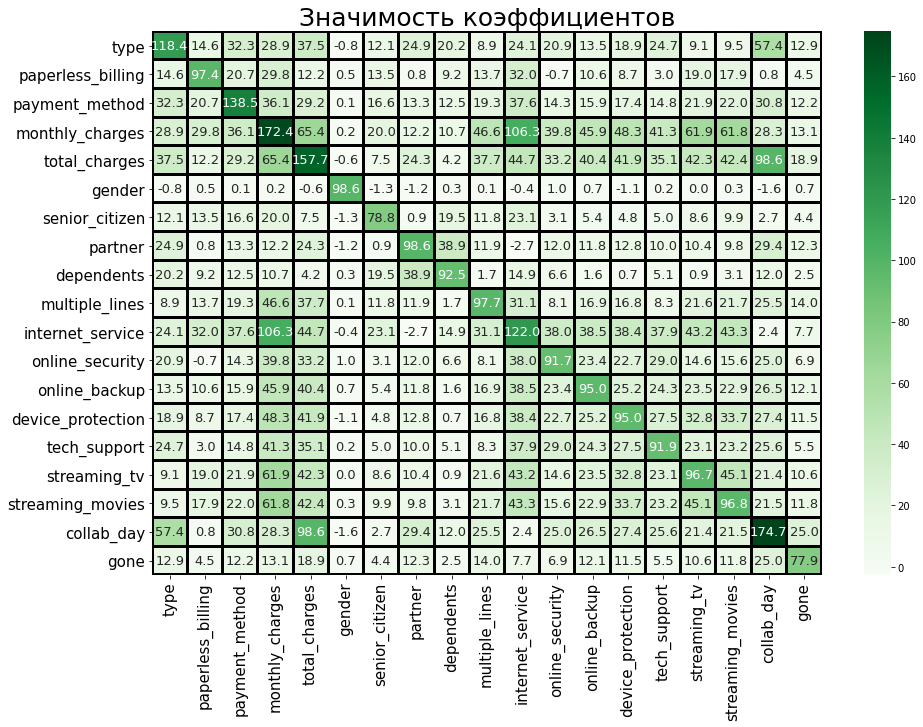

CPU times: user 1min 21s, sys: 456 ms, total: 1min 21s
Wall time: 1min 22s


In [65]:
%%time
plt.figure(figsize = (15, 10))
sns.heatmap(df.significance_matrix(),
            annot=True,
            annot_kws={'size': 13},
            fmt='.1f',
            cmap='Greens',
            linewidths=2,
            linecolor='black')
plt.tick_params(labelsize=15) 
plt.title(r'Значимость коэффициентов', fontsize=25)
plt.show()

### Разобьём данные на выборки

In [66]:
X = df.drop('gone', axis=1)
y = df['gone']

In [67]:
X.shape, y.shape

((7043, 18), (7043,))

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

In [69]:
# проверим длины наших выборок
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5282, 18), (5282,), (1761, 18), (1761,))

### Создадим списки категориальных и числовых столбцов

In [70]:
X_cat = list(X_train.select_dtypes(include=['category']).columns)
X_num = list(X_train.select_dtypes(exclude=['category']).columns)

**Вывод по пункту 4:**   
- удалили лишние столбцы    
- разбили данные на выборки   
- сохдали списки категориальных и числовых столбцов

## Обучение моделей

In [71]:
# подготовим для пайплайна обработку фичей
preprocessor = make_column_transformer(
 (StandardScaler(), X_num),
 (OneHotEncoder(drop='first', sparse=False), X_cat)
)

### Логическая регрессия

In [73]:
pipe_LR = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("model_LR", LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')),
    ]
)
grid_par_LR = {'model_LR__C': np.arange(0.75, 0.85, 0.01)}
cv_LR = GridSearchCV(pipe_LR, grid_par_LR, scoring='roc_auc', verbose=1)

In [74]:
%%time
t0 = time()
cv_LR.fit(X_train, y_train)
print(f'Лучший параметр: {cv_LR.best_params_}\nЛучший показатель ROC-AUC для логистической регрессии: {cv_LR.best_score_:.6f}')
end_LR = time() - t0

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучший параметр: {'model_LR__C': 0.81}
Лучший показатель ROC-AUC для логистической регрессии: 0.762214
CPU times: user 20 s, sys: 19.1 s, total: 39.2 s
Wall time: 39.2 s


In [76]:
cv_LR.best_estimator_.steps[1][1].coef_

array([[-0.18847778, -1.13039215,  0.14206563,  0.00755599,  1.36735666,
         1.56639676,  0.07983544, -0.02839922, -0.30880026, -0.70438147,
         0.0816017 ,  0.67107802, -0.15727612,  0.90083788,  0.93415591,
        -0.17405697,  0.34641413,  0.81699551,  0.48122127, -0.05048586,
         0.52170654,  0.48135982]])

In [77]:
res_LR = ['Логическая регрессия', f'{end_LR/60:.2f} минут', round(cv_LR.best_score_, 4)]

### Случайный лес

In [78]:
pipe_RF = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("model_RF", RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')),
    ]
)
grid_par_RF = {'model_RF__max_depth': range(5, 9),
               'model_RF__n_estimators': range(440, 445)}
cv_RF = GridSearchCV(pipe_RF, grid_par_RF, scoring='roc_auc', verbose=2)

In [79]:
%%time
t0 = time()
cv_RF.fit(X_train, y_train)
print(f'Лучший параметр: {cv_RF.best_params_}\nЛучший показатель ROC-AUC для RandomForest: {cv_RF.best_score_:.6f}')
end_RF = time() - t0

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=440; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=440; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=440; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=440; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=440; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=441; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=441; total time=   1.3s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=441; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=441; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=441; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_estimators=442; total time=   1.2s
[CV] END ..model_RF__max_depth=5, model_RF__n_e

In [81]:
res_RF = ['Случайный лес', f'{end_RF/60:.2f} минут', round(cv_RF.best_score_, 4)]

### Дерево решений

In [82]:
pipe_DT = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("model_DT", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')),
    ]
)
grid_par_DT = {'model_DT__max_depth': range(2, 10)}
cv_DT = GridSearchCV(pipe_DT, grid_par_DT, scoring='roc_auc', verbose=1)

In [83]:
%%time
t0 = time()
cv_DT.fit(X_train, y_train)
print(f'Лучший параметр: {cv_DT.best_params_}\nЛучший показатель ROC-AUC для DT: {cv_DT.best_score_:.6f}')
end_DT = time() - t0

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучший параметр: {'model_DT__max_depth': 5}
Лучший показатель ROC-AUC для DT: 0.784806
CPU times: user 2.05 s, sys: 1.52 ms, total: 2.05 s
Wall time: 2.07 s


In [85]:
res_DT = ['Дерево решений', f'{end_DT/60:.2f} минут', round(cv_DT.best_score_, 4)]

### CatBoost

In [86]:
%%time
grid_par_CB = {'learning_rate': [0.08, 0.09, 0.1]}
model_CB = CatBoostClassifier(random_state=RANDOM_STATE, cat_features=X_cat)
cv_CB = GridSearchCV(model_CB, grid_par_CB, scoring='roc_auc', verbose=2)

CPU times: user 158 µs, sys: 13 µs, total: 171 µs
Wall time: 177 µs


In [87]:
%%time
t0 = time()
cv_CB.fit(X_train, y_train)
print(f'Лучший параметр: {cv_CB.best_params_}\nЛучший показатель ROC-AUC для CatBoost: {cv_CB.best_score_:.6f}')
end_CB = time() - t0

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0:	learn: 0.6265088	total: 55.9ms	remaining: 55.8s
1:	learn: 0.5727461	total: 62.2ms	remaining: 31s
2:	learn: 0.5342485	total: 69.2ms	remaining: 23s
3:	learn: 0.4995010	total: 75.5ms	remaining: 18.8s
4:	learn: 0.4704734	total: 82.8ms	remaining: 16.5s
5:	learn: 0.4462608	total: 89.5ms	remaining: 14.8s
6:	learn: 0.4341460	total: 92.6ms	remaining: 13.1s
7:	learn: 0.4170571	total: 100ms	remaining: 12.4s
8:	learn: 0.4048756	total: 106ms	remaining: 11.7s
9:	learn: 0.3953876	total: 113ms	remaining: 11.2s
10:	learn: 0.3837340	total: 120ms	remaining: 10.8s
11:	learn: 0.3753426	total: 128ms	remaining: 10.5s
12:	learn: 0.3685662	total: 134ms	remaining: 10.2s
13:	learn: 0.3615334	total: 141ms	remaining: 9.91s
14:	learn: 0.3575877	total: 147ms	remaining: 9.65s
15:	learn: 0.3554402	total: 150ms	remaining: 9.22s
16:	learn: 0.3510580	total: 156ms	remaining: 9.03s
17:	learn: 0.3467890	total: 162ms	remaining: 8.84s
18:	learn: 0.3451197	total: 1

In [89]:
res_CB = ['CatBoost', f'{end_CB/60:.2f} минут', round(cv_CB.best_score_, 4)]

**Значимость коэффициентов**

In [90]:
X_imp_CB = pd.DataFrame({'features':X_train.columns,'feature_importance':cv_CB.best_estimator_.feature_importances_})
X_imp_CB = X_imp_CB.set_index('features')
X_imp_CB.sort_values('feature_importance',ascending=False)

,feature_importance
features,
collab_day,41.090690
monthly_charges,11.179549
total_charges,11.043962
type,8.491096
payment_method,5.104369
partner,3.364887
internet_service,2.799202
multiple_lines,2.320706
gender,1.945275


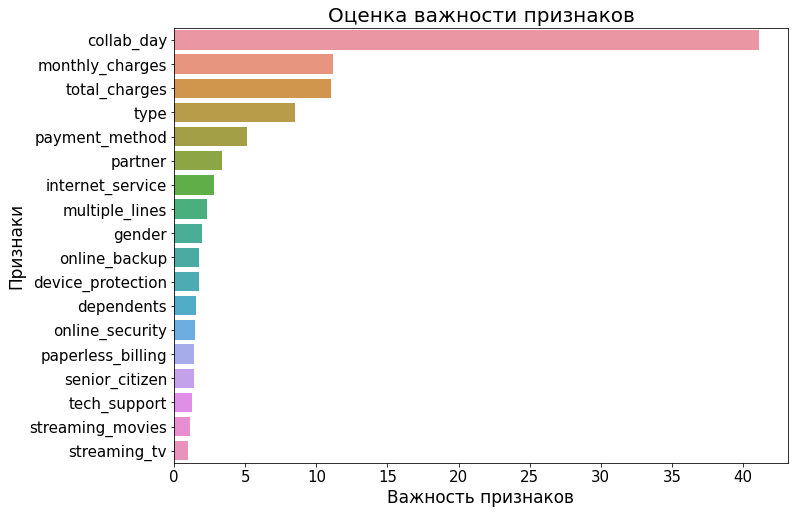

In [91]:
plt.figure(figsize=(11, 8))
sns.barplot(x=X_imp_CB['feature_importance'], y=X_imp_CB.index, order=X_imp_CB\
                .sort_values('feature_importance', ascending=False).index)
plt.title('Оценка важности признаков', fontsize=20)
plt.xlabel('Важность признаков', fontsize=17)
plt.ylabel('Признаки', fontsize=17)
plt.tick_params(labelsize=15) ;

**Посмотрим на результаты**

In [92]:
res_tab = [res_LR, res_RF, res_DT, res_CB]
columns = ['Модель', 'Время работы', 'ROC-AUC']
res_df = pd.DataFrame(res_tab,  columns=columns)
res_df = res_df.set_index('Модель')
res_df

,Время работы,ROC-AUC
Модель,,
Логическая регрессия,0.65 минут,0.7622
Случайный лес,2.32 минут,0.8153
Дерево решений,0.03 минут,0.7848
CatBoost,2.15 минут,0.9086


**Вывод по пункту 5:**  

Мы обучили четыре модели:    
+ модель логической регрессии  
+ модель решающего дерева
+ модель ансамбля деревьев    
+ модель градиентного бустинга       

Лучшей себя показала модель градиентного бустинга CatBoost с метрикой ROC-AUC = 0.908625.

## Тестирование лучшей модели

### Тестирование

In [93]:
proba_test_CB = cv_CB.best_estimator_.predict_proba(X_test)

auc_roc_CB = roc_auc_score(y_test, proba_test_CB[:, 1])
print(f'Показатели ROC-AUC модели CatBoost = {auc_roc_CB:.4f}')

pred_test_CB = cv_CB.best_estimator_.predict(X_test)
print(f'Показатели accuracy модели CatBoost = {accuracy_score(y_test, pred_test_CB):.4f}')

print(f'Полнота = {recall_score(y_test, pred_test_CB):.4f}')
print(f'Точность = {precision_score(y_test, pred_test_CB):.4f}')
print(f'F-1 мера = {f1_score(y_test, pred_test_CB):.4f}')

Показатели ROC-AUC модели CatBoost = 0.9148
Показатели accuracy модели CatBoost = 0.9148
Полнота = 0.5273
Точность = 0.8788
F-1 мера = 0.6591


**Посмотрим на метрику Dummy-модели.**

In [94]:
model_dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
model_dummy = model_dummy.fit(X_train, y_train).score(X_test, y_test)
print(f'Показатели accuracy модели Dummy = {model_dummy:.4f}')
print(f'Показатели accuracy модели CatBoost = {accuracy_score(y_test, pred_test_CB):.4f}')

Показатели accuracy модели Dummy = 0.8438
Показатели accuracy модели CatBoost = 0.9148


**Нашу модель можно считать адекватной. Показатели нашей модели значительно выше константной модели.**

### Построим график ROC-кривой.

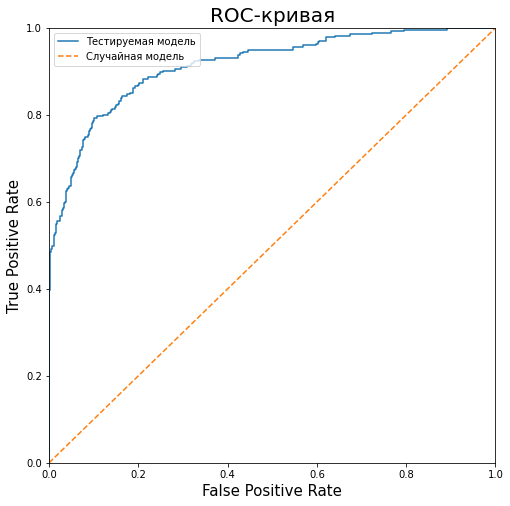

In [95]:
prob_test_one = proba_test_CB[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, prob_test_one)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')
#   установим границы осей от 0 до 1 >
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC-кривая', fontsize=20)
plt.legend(('Тестируемая модель', 'Случайная модель'), loc= 'upper left') 
plt.show()

### Построим матрицу ошибок

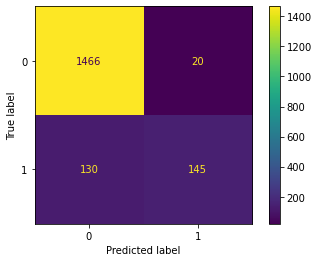

In [96]:
cm = confusion_matrix(y_test, pred_test_CB)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

**Вывод по пункту 6:**       
+ показатели ROC-AUC модели CatBoost = 0.908625 на тесте и 0.9148 на тесте, что больше 0,85.     
+ модель можно считать адекватной     
+ распределение классов у нас идёт 6:1. CatBoost-модель намного лучше предсказыват 0.
+ для улучшения метрики можно изменить threshold

## Отчёт по решению

В нашем распоряжении были четыре датасета:   

- contract_new.csv — информация о договоре;   
- personal_new.csv — персональные данные клиента;   
- internet_new.csv — информация об интернет-услугах;   
- phone_new.csv — информация об услугах телефонии.   

Во всех файлах столбец customerID содержит код клиента.  

**и имелись следующие признаки:**   

contract_new.csv:    
- customerID - идентифакионный номер покупателя
- BeginDate - дата начала обслуживания 
- EndDate - дата окончания обслуживания
- Type - тип оплаты: месяц, год, два
- PaperlessBilling - безналичный расчет
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячные траты на услуги
- TotalCharges - всего потрачено денег на услуги

personal_new.csv:  
- customerID - идентифакионный номер покупателя  
- gender - пол покупателя   
- SeniorCitizen	- наличие пенсионного статуса по возрасту 
- Partner -  наличие супруга(и)
- Dependents - наличие иждивенцев

internet_new.csv:  
- customerID - идентифакионный номер покупателя  
- InternetService - тип подключения
- OnlineSecurity - блокировка небезопасных сайтов 
- OnlineBackup - облачное хранилище файлов для резервного копирования данных
- DeviceProtection - защита устройства  
- TechSupport - линия технической поддержки
- StreamingTV - телевидение  
- StreamingMovies - каталог фильмов

phone_new.csv:
- customerID - идентифакионный номер покупателя  
- MultipleLines - наличие возможности ведения параллельных линий во время звонка

**Цель:** построить модель для задачи классификации, которая спрогнозирует уход клиента 

**Основная метрика: AUC-ROC.**     
Дополнительная метрика: Accuracy.

**Наша работа состояла из шести этапов:**

### Загрузка и изучение данных.

1. Загрузили необходимые библиотеки т написали окно импортов  
    - там же прописали RANDOM_STATE = 280823
    
    
2. Загрузили данные    


3. Написали функцию для описания и просмотра данных и выяснили, что
   - пропусков нет
   - дубликаты отсутствуют
   - есть необходимость объединить таблицы
   - нужно привести названия столбцов к snake-case
   - нужно изменить тип данных "TotalCharges" на float
   - для исследовательского анализа можно привести типы в столбцах EndDate и BeginDate к дате

###  Предобработка данных

1. Объединили таблицы с помощью  merge с типом объединения "left".
    - проверили правильность объединения      
    
    
2. С помощью библиотеки clean_columns привели названия столбцов к snake-case   


3. Создали новый столбец (таргет) на основании значений EndDate с названием "gone"   
    - если присутствовала дата окончания обслуживания, то значение в целевом признаке ставили 1, в противном случае 0
    - проверили количество значений
    
    
4. Заменили значение "No" в EndDate на дату выгрузки данных, изменим тип данных на datetime и создали столбец продолжительности сотрудничества в днях на разнице дат с названием "collab_day"    


5. В результате слияния таблиц появились пропуски у клиентов, которые не пользуются данными услугами. Их, что логично, мы заполнили значением "No".    


6. При попытке изменения тина данных в столбце "total_charges", обнаружились 11 клиентов, которые только подключились и имели на месте значений пустые строки. Мы заменили значения на 0 и привели столбец к типу данных "float". Также изменили тип "oblect" на "category".
    - проверили корректность совершённых действий    

### Исследовательский анализ данных

На этом этапе работы мы выяснили, что:         


1. Распределение таргета не равномерно 6:1, тех кто не ушёл и тех кто ушёл     


2. Продолжительность сотрудничества зависит от типа договора    
    - дольше всего сотрудничают клиенты и которых тип договора оплаты на два года и меньше всего, у которых договор на ежемесячную оплату     

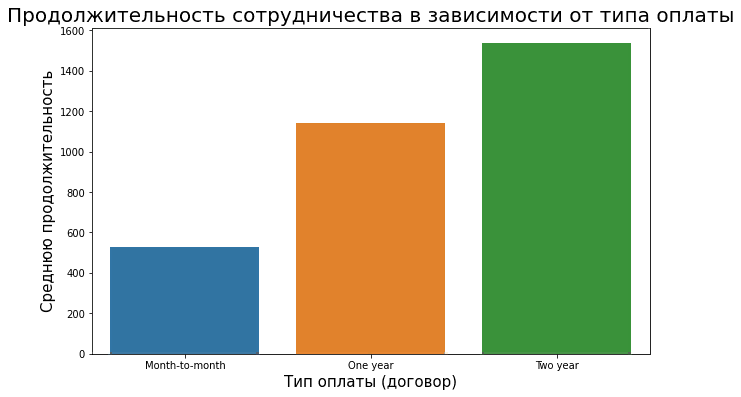

3. В 2019 количество ушедших клиентов сильно увеличилось, видимо нашли более выгодное предложение    


4. Уходили в основном клиенты, которые пришли к оператору связи в самом начале   

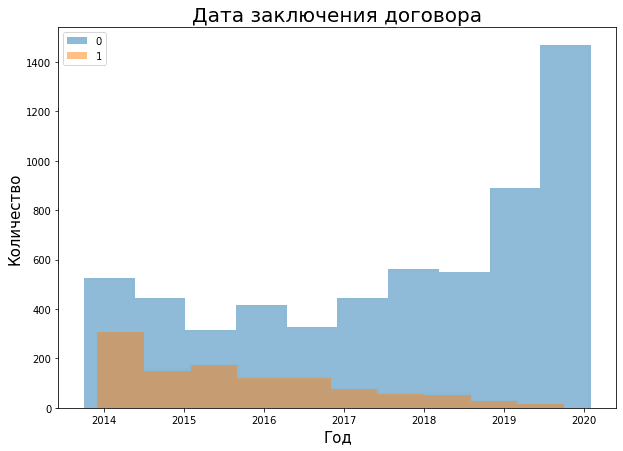

5. Также выяснили, что люди состоящие в браке уходят гораздо чаще

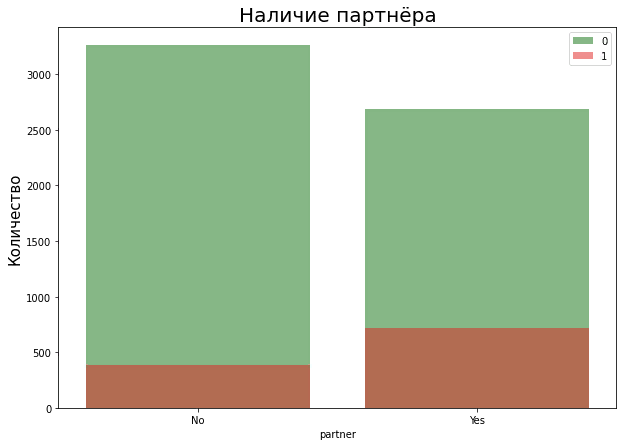

6. Также выяснили, что среди тех, кто ушёл было много людей с высоким ежемесячным плптежом.

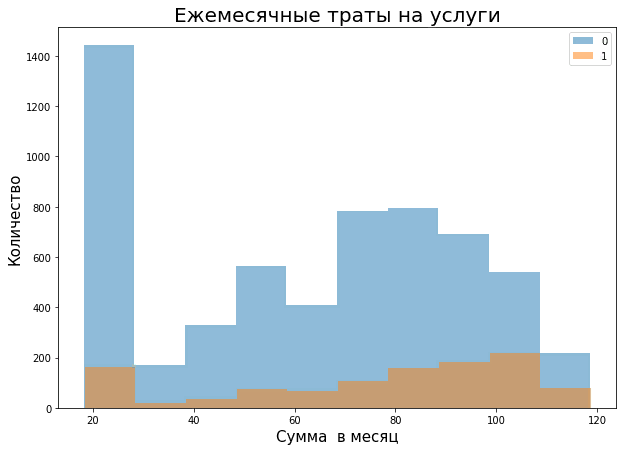

7. С помощью библиотеки phik построили тепловую карту корреляции признаков     
    - перед этим удалили столбец "customer_id"
    - по которой выяснили, что присутствует мультиколлениарность фичей "monthly_charges" с "internet_service", "streaming_tv", "streaming_movies", а также "total_charges" с "collab_day"  

### Подготовка данных к обучению

1. Мы удалили столбцы 'begin_date', 'end_date', так как на их основе был создан "collab_day". К тому же они не были нужны для анализа, учитывая, что мы не анализируем временные ряды.  


2. С помощью train_test_split разбили данные на выборки X_train, X_test, y_train, y_test с размером тестовой выборки равной 0.25 от начального датафрейма.   
    - проверили правильность разбиения


3. Создали списки категориальных и числовых признаков.

**В итоге для обучения у нас остались следующие признаки:**   

- Type - тип оплаты: месяц, год, два
- PaperlessBilling - безналичный расчет
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячные траты на услуги
- TotalCharges - всего потрачено денег на услуги
- gender - пол покупателя   
- SeniorCitizen	- наличие пенсионного статуса по возрасту 
- Partner -  наличие супруга(и)
- Dependents - наличие иждивенцев
- InternetService - тип подключения
- OnlineSecurity - блокировка небезопасных сайтов 
- OnlineBackup - облачное хранилище файлов для резервного копирования данных
- DeviceProtection - защита устройства  
- TechSupport - линия технической поддержки
- StreamingTV - телевидение  
- StreamingMovies - каталог фильмов
- MultipleLines - наличие возможности ведения параллельных линий во время звонка   
- collan_day - столбец продолжительности сотрудничества в днях

### Обучение моделей

1. С помощью функции "make_column_transformer" совместили методы предварительной обработки StandardScaler для числовых признаков и OneHotEncoder для категориальных.   

#### Логическая регрессия

1. В конвейере прописали этапы предобработки и модель    


2. Прописали варианты параметров для подбора     


3. Для подбора параметров использовали GridSearchCV - инструмент для автоматического подбирания параметров и кроссвалидации для моделей машинного обучения из библиотеки scikit-learn     


4. Обучили модель     


5. Вывели лучшие гиперпареметры и лучшую метрику AUC-ROC    

#### Случайный лес

#### Дерево решений

Модели "Случайный лес" и "Дерево решений" прошли те же этапы, что и "Логическая регрессия".

#### CatBoost

Эта модель тоже прошла те же этапы, за исключением этапов предобработки, т.к. эта модель обрабатывает их самостоятельно.   

**По итогам этого этапа лучшей показала себя модель CatBoost с результатами:**

Лучший параметр: 'learning_rate': 0.09         
Лучший показатель ROC-AUC для CatBoost: 0.908625        
Время обучения: 2min 20s

Также рассмотрели важность признаков для модели

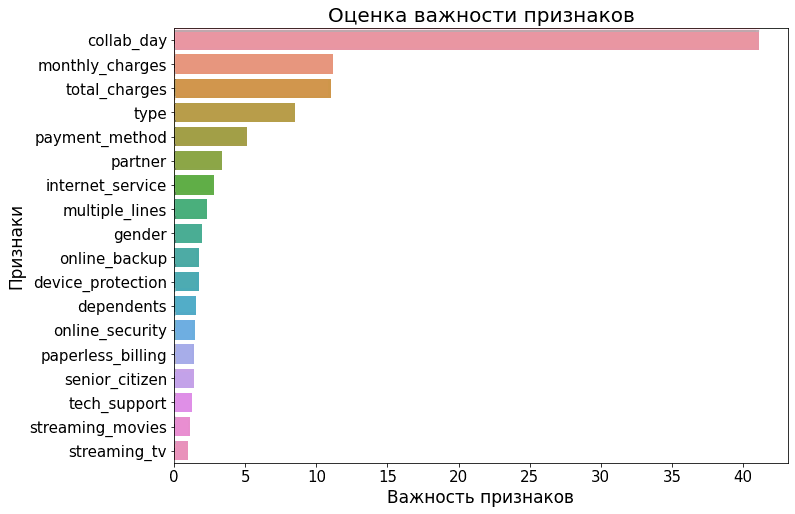

Самым важным оказался, созданный нами признак - collab_day (продолжительность сотрудничества в днях)

Также рассматривалась версия для сокращения количества признаков, но она была отброшена, по причине уменьшения метрики.

### Тестирование лучшей модели

**На тестировании модель показала следующие результаты:**      

Показатели ROC-AUC модели CatBoost = 0.9148     
Показатели accuracy модели CatBoost = 0.9148       
Полнота = 0.5273    
Точность = 0.8788     
F-1 мера = 0.6591    

**Сравнили метрики нашей модели с константной**

Показатели accuracy модели Dummy = 0.8438     
Показатели accuracy модели CatBoost = 0.9148   

**Построили ROC-кривую**

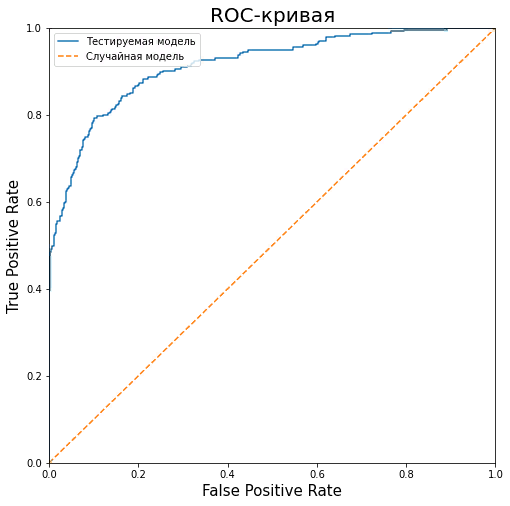

**Также для неё построили матрицу ошибок**

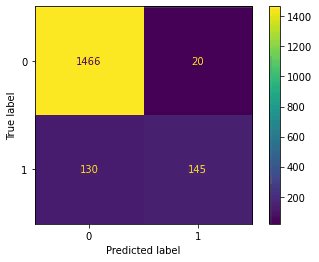

+ Полнота нашей модели имеет показатель 0.52 и показывает вероятность ухода клиента (доля TP-ответов среди всех, у которых истинная метка 1). 
+ Точность: модель предскажет уход клиента в почти 88% случаев. 
+ Также достигли неплохого результата площади под ROC-кривой — AUC-ROC = 0.9148, что больше 0.85.

**Учитывая тот факт, что нам нужно было спрогнозировать, уйдёт клиент в ближайшее время или нет,  данная модель вполне подойдёт.**

**Также в дальнейшем для опрератора связи нужно больше обращать внимание на клиентов, которые могут уйти:**    
- у которых договор оплаты на месяц    
- клиенты с большой длительностью сотрудничества    
- состоящие в браке   
- с высоким ежемесячным платежом    

## Совпадение с планом

**Наша работа практически совпадает с исходным планом работы. За исключением того, что исследование на мультиколлинеарность в работе находится в Исследовательском анализе, а в плане в Предобработке.**

## Трудности в работе

**Трудностей, с которыми нельзя было бы справиться не возникло, за исключением (как обычно) нехватки времени на выполнение данного проекта. То есть первую неделю было очень много дел и проекту уделял мало времени.**

## Ключевые этапы проекта

**На самом деле в проекте важны все этапы. Не сделаешь предобработку данных или не создашь дополнительные признаки и т.п. и модель покажет плохую метрику. Если не исследуешь данные, вообще не будешь понимать что перед тобой))) Поэтому в работе нет лишних этапов или важных и неважных. Здесь все этапы ключевые)**